In [2]:
import matplotlib.pyplot as plt
from atlasreader import create_output
import os
from os.path import join as opj
import itertools
from glob import glob
import pandas as pd 
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,sem
import matplotlib.patches as mpatches
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind, ttest_1samp
%matplotlib inline
import numpy as np
from scipy.stats import pearsonr,sem,ttest_rel
import os.path as op
from sklearn.model_selection import StratifiedKFold
import nipype_init_new
nipype_init_new.init()
from skbold.core import MvpWithin, convert2mni, convert2epi
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score
from nilearn.image import load_img, concat_imgs, index_img, smooth_img, resample_to_img, smooth_img, mean_img, new_img_like
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, view_img
from nilearn.decoding import SearchLight
#import mvpa2.suite as mvpa2


In [3]:
def show_cluster(data,ds,options=""):
    result_file = mvpa2.map2nifti(ds,data=data)
    result_file.to_filename('temp_result.nii.gz')

    !{'cluster --in=temp_result.nii.gz --mm ' + options}  

In [4]:
def ensure_dir(ed):
    try: 
        os.makedirs(ed)
    except OSError:
        if not os.path.isdir(ed):
            raise

In [5]:
def partial_corr(iv,dv,covariate):
    import scipy as sp
    import numpy as np
    # add intercept to covariate
    regress = np.vstack([covariate,np.ones(len(covariate))]).T

    #perform a normal linear least-squares regression with X as the target and Z as the predictor
    iv_regress, residuals, rank, s = np.linalg.lstsq(regress,iv)

    #calculate the residuals in Step #1
    iv -= regress.dot(iv_regress)

    #perform a normal linear least-squares regression with Y as the target and Z as the predictor
    dv_regress, residuals, rank, s = np.linalg.lstsq(regress,dv)
    dv -= regress.dot(dv_regress)

    r,p = sp.stats.pearsonr(iv,dv)

    df = len(dv)-2
    tval = r * np.sqrt(df/(1-r**2))
    p1 = sp.stats.t.sf(np.abs(tval),len(dv)-2)*2
    
    return r,p,tval,iv,dv

In [6]:
def read_design(design_file):
        import itertools
        import os.path as op
        import pandas as pd
        if not op.isfile(design_file):
            raise IOError('There is no design.con file for %s' % design_file)

        # Find number of contrasts and read in accordingly
        with open(design_file, 'r') as dfile:
            lines = dfile.readlines()
            contrasts = sum(1 if 'ContrastName' in line else 0
                            for line in lines)
            n_lines = sum(1 for line in lines)

        df = pd.read_csv(design_file, delimiter='\t', header=None,
                         skipfooter=n_lines - contrasts, engine='python')

        cope_labels = list(df[1].str.strip())  # remove spaces

        # Here, numeric extensions of labels (e.g. 'positive_003') are removed
        labels = []
        for c in cope_labels:
            parts = [x.strip() for x in c.split('_')]
            if parts[-1].isdigit():
                label = '_'.join(parts[:-1])
                labels.append(label)
            else:
                labels.append(c)

        return labels

# Brief Intro to the study

 In this manuscript, we set out to investigate whether we can **decode selfish versus prosocial motivations from neural patterns** during decision making in economic games. <br>
 
 We collected fMRI data from participants while they played 24 rounds of the Ultimatum and Dictator Game and related their behavior during these interactions to patterns of neural activation during decision-making, using machine learning methods. In these games participants have to decide how they want to divide an endowment (20 €) between themselves and another participant.  Because responders can reject the offer in the UG, but not the DG, offers and neural patterns between the games should differ for strategic players, but not prosocial players. Using novel machine-learning methods we found that particularly individual differences in the engagement of cognitive control and theory of mind, which refers to the inference and understanding of another person’s beliefs and intentions, drive decisions to be fair and prosocial.  
 
How we did this will be explained throughout this presentation.
  
  <img src="img/UG_new.png" alt="Drawing" heigth="150" width="1000">
 
 
  <img src="img/DG.png" alt="Drawing" heigth="150" width="1000">
  



This is what one trial of the experiment looked like:

We only used the first 6s of each trial as this period was not contaminated by possible confounds related to button presses.

<img src="img/experiment_ug.png" alt="Drawing" heigth="150" width="1000">

# Part 1: Experimental design, pattern estimation, and data representation
Before you can do any fancy machine learning analysis (or any other pattern analysis), there are several decisions you need to make and steps to take in (pre)processing and structuring your data. Roughly, there are three steps to take:

1. Design your study in a way that's appropriate to answer your question through a pattern analysis; this, of course, needs to be done *before* data acquisition! <br> (The study I'm presenting today was not originally meant for MVPA analysis so may not be the best example e.g. runs, 3 of trials)

2. Estimate/extract your patterns from the (functional) MRI data;

3. Structure and represent your data appropriately for pattern analyses;

While we won't go into all the design factors that make for an *efficient* pattern analysis (see [this article](http://www.sciencedirect.com/science/article/pii/S105381191400768X) for a good review), we will now discuss/demonstrate some design considerations and how they impact the rest of the MVPA pipeline.

### 1.1. Designs for pattern analysis
There are many ways in which you can categorize different types of pattern analyses, but one of the most basic categorizations is in terms of whether analyses are **within-subject** or **between-subject**. The major distinction revolves around whether you want to investigate an (experimental) factor that varies or is manipulated **within** subjects or that varies **across** subjects (i.e. individual differences or experimental between-subject designs)\*.


Importantly, these two types of analyses differ in what is regarded as an *instance of a pattern* (also referred to as a *sample*):

- in **within**-subject analyses, *each instance of your feature-of-interest represents one pattern* (e.g., each single trial/stimulus/response);
- in **between**-subject analyses, *each subject represents one pattern*.

This distinction is important, because the choice of type of pattern analysis has major consequences for the design of your experiment and the methods available for pattern extraction. **Throughout this presentaiton, we focus on within-subject analyses**, using a simple two-class classifcation problem where we want to decode whether participants play an UG or DG at a given trial.

### 1.2. Pattern estimation for within-subject designs
There are different ways to estimate your patterns for pattern-based analyses. In our study we want to decode neural patterns associated with playing the UG versus the DG. In that case, you need to to estimate a pattern for each UG and each DG trial. Now, suppose we show a face of an opponent and whether or not he can reject the offer at 9 seconds, we can "extract" activity at each voxel for that stimulus in three ways (see figure below):

1. Extract just a point estimate of activity at, e.g., 6 seconds post-stimulus (expected HRF peak);
2. Average across a range of points;
3. Fit a HRF *per stimulus* and extract the corresponding $\beta$-parameter;

As method 3 (fitting a separate HRF per stimulus) has shown to yield the most stable pattern estimates ([Misaki et al., 2010](http://www.sciencedirect.com/science/article/pii/S1053811910007834)), we'll focus on that method in the rest of this section.

<img src="img/pattern_estimation_UG.png" alt="Drawing" heigth="150" width="1000">

We will extract *patterns* of $\beta$-estimates by fitting a hemodynamic response function (HRF) per trial using the general linear model (GLM)\*. In other words, "trials" (i.e. instances of your feature-of-interest) in within-subject designs are modelled as separate regressors in a first-level analysis. Below, we included an image of a single-trial design (of the hypothetical faces vs. houses experiment) as created in FSL:

<img src="img/design_ug.png" alt="Drawing">

----
__\* Note__: This single-trial design is also referred to as a "Least Squares All" (LSA) approach. Alternative pattern estimation designs exist, including "Least Squares Single" (LSS); the choice for one or the other depends on the trail-by-trial variability and scan-noise ([Adulrahman & Henson, 2017](http://www.sciencedirect.com/science/article/pii/S1053811915010319)).

As you can see, each trial gets it's own regressor (hence the name "single-trial design"). Then, as depicted below the design matrix, a contrast-against-baseline is created for each regressor (trial). After you run a first-level analysis using this design, you'll have whole-brain maps containing statistics values ($\beta$-values, *t*-values, or *z*-values) for each trial that represent the trial's estimated (whole-brain) pattern. Usually, *t*-values or *z*-values are used instead of $\beta$-values (cf [Misaki et al., 2010](http://www.sciencedirect.com/science/article/pii/S1053811910007834)).

*Importantly, this design thus specifies that for each "trial" the activation per voxel is estimated, e.g. each trial gets its own activation map*.


### 1.4. Visualizing patterns

Due to time constraints I will skip the part on how to implement the single trial estimation, but it is a standard procedure and there is lots of documentation online.

As a short summary on single trial estimation:
- Model each "trial" (or more generally, "instance") as a separate HRF-convolved regressor;
- Additionally define a contrast-matrix in which each trial is contrasted against baseline in order to create *t*-value/*z*-value patterns;

Alright, you now know what a single-trial (within-subject) design looks like and what it produces (i.e. single-trial pattern estimates in the form of whole-brain $\beta$/*t*-stat/*z*-stat maps). Before we go on, we will show what a pattern of a single trial looks like in fslview. This will hopefully give you some more "intuition" on what is meant with a single trial pattern. 

I'm using nilearn's plotting tools (https://nilearn.github.io/plotting/index.html), which are very convenient and easy to use!

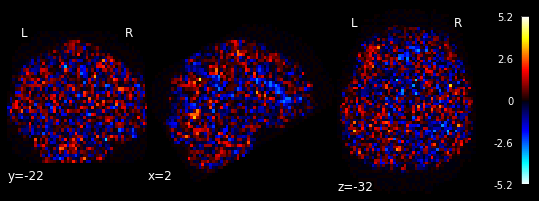

In [14]:
plot_stat_map('/data/sebastian/UG/Neural_data_D2/MVPA/_session_id_run_1_subject_id_UG04/modelest/firstlevel.feat/stats/tstat21.nii.gz',
             black_bg=True, bg_img=None, draw_cross=False)

<br>
What we visualized here is an example of a within-subject pattern of a particular trial ("sample"), in which the activated voxels (relative to baseline) are colored red/yellow, and the deactivated voxels (relative to baseline) are colored blue/lightblue. Make sure you understand how this image represents the pattern of a single sample.
</div>

#### 1.4.1 Data representation
In pattern analyses, there is a specific way to 'store' and represent brain patterns: as 2D matrices of shape `N-samples` $\times$ `K-voxels`. **Important**: often (and confusingly), people refer to voxels as (brain) 'features' in pattern analyses. So in articles people often refer to samples-by-features matrices!

Anyway, this is what such a matrix looks like for the hypothetical faces-vs-houses decoding study: 
<img src="img/data_rep_UG.png" alt="Drawing" heigth="100" width="500">

Each row thus represents the voxel pattern of a sample (here: trial)!


In [ ]:
## Very useful python package: skbold (developed at UvA)
While it's still relatively easy to load in, structure, and preprocess all of the data necessary for pattern-based analyses, there's quite a lot of "boilerplate code", especially when you need to loop your analysis across multiple participants. [skbold](skbold.readthedocs.io), a (Python-based) package offers a set of tools to make machine learning analyses of fMRI data easier. As shown in the figure below, skbold offers functionality specific to fMRI-data at different stages of your machine learning pipeline. For example, reading in single-trial estimates and corresponding labels ("y") only takes about 5 lines of Python code using skbold. Skbold will also convert 3D nifti images into the 2D representation presented above...

<img src="img/skbold_scope.png" alt="Drawing" heigth="50" width="1000">


## 2. MVPA (Multi Voxel (Variate) Pattern Analysis)



### 2.1. An overview of a typical machine learning pipeline

Now, we're ready to learn how to actually implement decoding pipelines. Typical pipelines consist of the following elements:

* Data preprocessing (scaling)
* Data partitioning
* Feature selection/extraction
* Model fitting (on train-set)
* Model cross-validation (on test-set)
* Calculate model performance
* Statistical analyses of performance

I will show you by means of an example how I implemented such an analysis pipline on our UG/DG Dataset

### 2.3. Pattern preprocessing (scaling)
Before any machine learning analysis, is it advised to preprocess your pattern such that each feature (here: voxels) is on the same scale. This "feature scaling" process can be done in various ways, but the most often used method is *standardization*: scaling features such that they have 0 mean and unit variance. Feature scaling is important for many machine learning algorithms in the training process and omitting scaling may yield sub-optimal results.

Scikit-learn provides a class, [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), that implements feature standardization. We'll apply it to our entire dataset (`X`) here, but strictly speaking it's best to "cross-validate" this preprocessing step.


#### load data from one participant using skbolds functionalitz:

In [47]:
# path for neural data
subj='sub19'
source=glob(op.join( '/data', 'sebastian', 'UG','Firstlevel_KPbased_Maarten_6s', 'MVPA','*_session*%s*'%subj,'modelest','*.feat'))

#specify mask - in this case the ToM mask 
mask_threshold=0.5
base_dir='/data/sebastian/UG/ROI_Analysis/neurosynth/'
empathy_map=glob(opj(base_dir,'ToM*.nii.gz'))[0]



# load in the neural data
mvp = MvpWithin(source=source, read_labels=True,
                ref_space='epi', statistic='tstat',
                remove_zeros=True,
                # selecting the human UG-DG only
                remove_contrast = ['3.0','4.0','7.0','8.0','KP'],
                mask=empathy_map,
                mask_threshold=mask_threshold
               )
mvp.create()

# get the Game Type
mvp.y=np.where(mvp.y % 2 == 0, 1, 2)

y=mvp.y

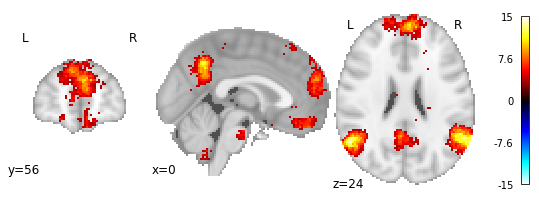

In [25]:
# in case you were wondering what the ToM mask looks like:
plot_stat_map(empathy_map, draw_cross=False)

In [48]:
# this is our neural data in 2D format each row represents a trial and each column represents a voxel feature
mvp.X

array([[ 2.05011153, -0.7293613 ,  0.8389442 , ...,  0.2744233 ,
         0.24661392,  1.13299966],
       [ 0.06542181,  0.71896809,  0.8420797 , ..., -0.64721376,
         0.24576142,  0.5097611 ],
       [ 0.59112316,  1.75896454,  0.77552456, ..., -1.05729425,
        -1.93498063, -0.42438713],
       ...,
       [ 0.65456814, -0.46399048,  0.0549469 , ..., -0.78935921,
         1.27278626,  0.8001864 ],
       [-0.64422023, -0.65250045,  0.83153903, ...,  0.74707812,
        -1.17459846, -2.25325155],
       [ 0.35850015, -0.50438488, -0.53072774, ...,  0.48814714,
        -0.0871783 ,  0.03435417]])

In [49]:
# here are the dimensions of the neural data extracted from the ToM mask: 24 trial - 2678 voxel
# with 3*3*3 voxel resolution the typical brain has approximately 40 000 voxels so using only the ToM network has already significantly reduced the Nr of voxels
mvp.X.shape

(24, 3405)

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Here we initialize the StandardScaler object
scaler.fit(mvp.X)             # Here we "fit" the StandardScaler to our entire dataset (i.e. calculates means and stds of each feature)
X = scaler.transform(mvp.X)   # And here we transform the dataset using the calculated means/stds

Did the scaling procedure work? Let's check that below (by asserting that the mean of each column is 0, and the std of each column is 1):

In [51]:
means = np.mean(X, axis=0)
np.testing.assert_almost_equal(means, np.zeros(X.shape[1]))
print("Each column (feature) has mean 0!")
stds = X.std(axis=0)
np.testing.assert_almost_equal(stds[stds != 0], np.ones((stds != 0).sum()))
print("Each column (feature) has std 1!")

Each column (feature) has mean 0!
Each column (feature) has std 1!


### 2.4. Model fitting & cross-validation
First, I'll show you how to use scikit-learn models and associated functionality. In fact, the most useful functionality of scikit-learn is probably that they made fitting and cross-validating models easy. 

Note that in the upcoming example, we will fit the model on *all* our samples for the sake of the example. In practice, this is something you would **never** do: you always need to cross-validate your model to a new, independent sample.**\*** 

----
**\*** That is, independent with respect to noise: the noise in your *training* sample should not be correlated with the noise in your *test* set).

Anyway, let's import a scikit-learn model: the (linear) support vector classifier ([SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)), which is one of the most-often used models in fMRI pattern analyses. In scikit-learn, this model is part of the`svm` module.

Like most of scikit-learn's functionality, SVC is a *class* (not a *function*!). So, let's initialize an SVC-object! One important argument that this object needs upon initialization is the ["kernel"](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html) you want the model to have. Basically, the kernel determines how to treat/process your features: linearly (such as `kernel='linear'`), or non-linearly (such as the `kernel='rbf'` or `kernel='poly'` options). Most often a linear kernel is the best option (as non-linear kernels often overfit very quickly).

To initialize an SVC-object with a linear kernel, just do as follows:

In [52]:
# load SVC class from svm module
from sklearn.svm import SVC

# clf = CLassiFier
clf = SVC(kernel='linear')

Now, you need to do two thing to get the prediction for each sample: 
1. fit, using the method `fit(X, y)`, and predict the class (i.e. 1 = UG or 2 = DG) for each class using the method `predict(X)`. Basically, in the `fit` method, the parameters of the model (i.e. $\beta$) are estimated. 
2. Then, in the `predict` method, the estimated parameters are used to generate a prediction for each sample (i.e. 1 or 2). 

Let's first look at the `fit` method. As you can see, the `fit(X, y)` method needs two parameters: X (a samples-by-features matrix) and y (a vector of length n-samples). Let's do that for our data: 

In [53]:
print('Fitting SVC ...')
clf.fit(X, y)
print(' done.')

Fitting SVC ...
 done.


To get the prediction of any sample, just call the `predict(X)` method of the model, which returns the predictions as an array:

In [54]:
y_hat = clf.predict(X)
print("The predictions for my samples are:\n %r" % y_hat.tolist())

The predictions for my samples are:
 [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]


### 2.5. Model evaluation
A logical next step is to assess how good the model was in predicting the class of the samples. A straightforward metric to summarize performance is *accuracy* **\*** which can be defined as: 

\begin{align}
accuracy = \frac{number\ of\ correct\ predictions}{number\ of\ predictions}
\end{align}

---------------
**\*** There are waaaay [more metrics to summarize model performance](http://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/) for classification models, such as precision, recall, F1-score, and ROC-AUC. These metrics are more appropriate than accuracy when you have *imbalanced classes*, i.e. more samples in one class (e.g. negative images) than in another class (e.g. positive images). Fortunately, in this data set UG and DG trials are balanced so the simple accuracy metric will do.

In [55]:
accuracy=(y_hat==y).sum()/len(y)
print(accuracy)

1.0


### 2.6 Cross validation

The accuracy was 1.0 - a perfect score! "Awesome! Nature Neuroscience material!", you might think. But, as is almost always the case: if it seems too good to be true, it probably *is* indeed too good to be true.

So, what is the issue here? 

Well, we didn't cross-validate the model! We fitted it on all the samples in the mvp-object and predicted the *same* samples, which leads to optimistic estimate of model performance. Such optimistic estimates in uncross-validated models are especially likely when there are many more features (here: voxels) than samples (here: trials). In other words, we are probably *overfitting* the model here.

Thus, let's check what happens if we actually cross-validate the model. To do so, we need to partition the data into a train- and test-set. 

Now, we can finally use some of scikit-learn's functionality. We are going to use the [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) class from scikit-learn's model_selection module. Click the highlighted link above and read through the manual to see how it works.

Importantly, if you're dealing with a classification analysis, always use *Stratified*KFold (instead of the regular [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)), because this version makes sure that each fold contains the same proportion of the different classes (here: 1 and 2). This is particularly important if you have imbalanced classes. 

Let's initialize a StratifiedKFold object with 6 folds:

In [84]:
# scikit-learn is imported as 'sklearn'
from sklearn.model_selection import StratifiedKFold

# They call folds 'splits' in scikit-learn
skf = StratifiedKFold(n_splits=6)

In [83]:

# run split() again to generate folds
folds = skf.split(X, y)

performance = np.zeros(skf.n_splits)

for i, (train_idx, test_idx) in enumerate(folds): # here we loop over the  folds and create indices for each fold
    
    # here we index the neural data into a train and test set - different samples (rows) are used in each fold
    X_train = X[train_idx,:] 
    y_train = y[train_idx]

    # here we index the dependent variable (UG vs DG) into a train and test set - different samples (rows) are used in each fold
    X_test =  X[test_idx,:]
    y_test =  y[test_idx]
    
    print("Shape X_train: %r" % (X_train.shape,))
    print("Shape y_train: %r" % (y_train.shape,))
    print("Shape X_test: %r" % (X_test.shape,))
    print("Shape y_test: %r" % (y_test.shape,))
    
    # fit the classifer on train data
    clf.fit(X_train,y_train)
    
    # predict on the test set
    y_hat_test = clf.predict(X_test)
    
    # calculate the performance for this fold using simple accuracy
    this_performance = accuracy_score(y_test, y_hat_test)

    
    performance[i] = this_performance
    
# average performance across folds
avperf= np.mean(performance)

print("Average performance across folds: %r" % (avperf))

Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Average performance across folds: 0.7083333333333334


## 2.8. Feature selection/extraction
While a complete discussion on (causes of) the phenomenon of "overfitting" is definitely beyond the scope of this presentation, it is generally agreed upon that a small sample/feature-ratio will likely lead to overfitting of your models (optimistic performance estimates on train-set). A small sample/feature ratio, unfortunately, is very common in machine learning analyses of neuroimaging (and especially fMRI) data, as the number of features (voxels, MEG sensors) often largely outnumber the amount of samples (trials or subjects).

Given that this small sample/feature ratio (usually) leads to overfitting, it follows that reducing the amount of features often has a beneficial effect on cross-validated performance estimates. (Or alternatively, increasing your number of samples, but this is not always feasible due to practical and financial reasons...)

Feature reduction can be achieved in two principled ways:

* feature extraction: transform your features into a set of lower-dimensional components;
* feature selection: select a subset of features

Examples of feature extraction are PCA (i.e. transform voxels to orthogonal components) and averaging features within brain regions from an atlas.

Examples of feature selection are ROI-analysis (i.e. restricting your patterns to a specific ROI in the brain) and "univariate feature selection" (UFS). This latter method is an often-used data-driven method to select features based upon their univariate difference, which is basically like using a traditional whole-brain mass-univariate analysis to select potentially useful features!

---
In our UG paper we used a combination of both feature selection methods:

We first used a ToM mask to narrow down features to voxels from potentially relevant regions and that did data driven feature selection on the remaining voxels within the cross validation.

### 2.8.1. (Univariate) feature selection
As an example of feature selection, let's take a closer look at how UFS can be implemented using scikit-learn. Basically, it follows the following structure:

```
transformer = Selector(score_func=ufs_function, other_args)
```

Here, the `score_func` parameter takes a function that implements a univariate statistical test (like an [f-test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) or a [chi-square test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.chi2)). The `Selector` class determines how to select the subset of features based on the result of the `score_func`. 

For example, the [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) selector selects the best `K` features based on their scores from the statistical test. For example, the following transformer would select the best 2000 features based on their F-score ( univariate comparison UG vs. DG):

In [90]:
from sklearn.feature_selection import SelectKBest, f_classif

# f_classif is a scikit-learn specific implementation of the F-test
select2000best = SelectKBest(score_func=f_classif, k=2000)

In [100]:
# Fit the transformer ...
select2000best.fit(X, y)

# ... which calculates the following attributes (.scores_ and .pvalues_)
# Let's check them out
scores = select2000best.scores_
pvalues =  select2000best.pvalues_

# As you can see, each voxel gets its own score (in this case: an F-score)
print(scores.size)

# and its own p-value:
print(pvalues.size)

print("Shape of X before transform: %r ..." % (X.shape,))
X_after_ufs = select2000best.transform(X)

print("... and shape of X after transform: %r." % (X_after_ufs.shape,))

3405
3405
Shape of X before transform: (24, 3405) ...
... and shape of X after transform: (24, 2000).


As you can see, the transformer correctly selected a subset of 2000 voxels from our X matrix! Now, both selectors were fit on the entire dataset, which is often course not how it should be done: because they use information from the labels (`y`), this step should be cross-validated. Thus, what you have to do is:

* fit your transformer on the train-set;
* transform your train-set;
* transform your test-set;
* (fit your model on the transformed train-set;)
* (cross-validate to the transformed test-set;)

We summarized the entire pipeline, including data partitioning (indexing), feature selection (transformation), and model fitting and their corresponding cross-validation steps in the image below:


<img src='img/pipeline_ug.png'>

## Putting it all together in one final pipeline

The pipeline illustrated above has been implemented in the code below:

In [94]:
from skbold.postproc import MvpResults
from sklearn.metrics import accuracy_score, f1_score

mvpr = MvpResults(mvp=mvp, n_iter=6, feature_scoring='forward', confmat=True,
                  accuracy=accuracy_score, f1=f1_score)

pipe_line = Pipeline([('scaler', StandardScaler()),
                      ('ufs', SelectKBest(score_func=f_classif, k=1000)),
                      ('clf', SVC(kernel='linear'))])


# run split() again to generate folds
folds = skf.split(X, y)

performance = np.zeros(skf.n_splits)

for i, (train_idx, test_idx) in enumerate(folds): # here we loop over the  folds and create indices for each fold
    
    # here we index the neural data into a train and test set - different samples (rows) are used in each fold
    X_train = X[train_idx,:] 
    y_train = y[train_idx]

    # here we index the dependent variable (UG vs DG) into a train and test set - different samples (rows) are used in each fold
    X_test =  X[test_idx,:]
    y_test =  y[test_idx]
    
    print("Shape X_train: %r" % (X_train.shape,))
    print("Shape y_train: %r" % (y_train.shape,))
    print("Shape X_test: %r" % (X_test.shape,))
    print("Shape y_test: %r" % (y_test.shape,))
    
    # here we implement the pipeline (including scaling, feature selection and classifier) on the training set
    pipe_line.fit(X_train, y_train)
    
    # and use it to make predictions from the test set
    pred = pipe_line.predict(X_test)
    
    # calculate the performance for this fold using simple accuracy
    this_performance = accuracy_score(y_test, y_hat_test)

    
    performance[i] = this_performance
    mvpr.update(test_idx=test_idx, y_pred=y_hat_test, pipeline=pipe_line)
# average performance across folds
avperf= np.mean(performance)

print("Average performance across folds: %r" % (avperf))

Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Shape X_train: (20, 3405)
Shape y_train: (20,)
Shape X_test: (4, 3405)
Shape y_test: (4,)
Average performance across folds: 0.75


### Feature visualization
using functionality from the skbold package we can here visualize the voxel obtained during feature selection, that were used for the decoding.

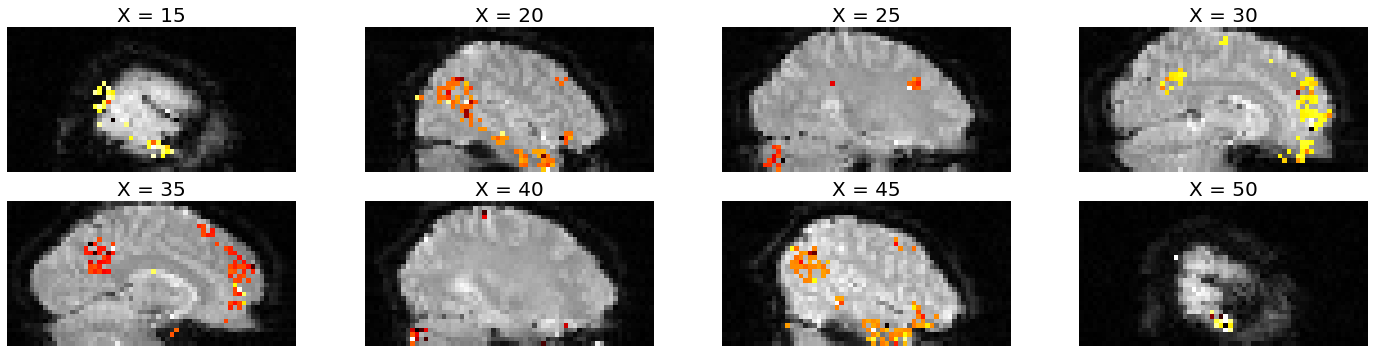

In [106]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 5))
scores_3d = feature_scores.get_data() # get the feature scores
background='/data/sebastian/UG/Neural_data_D1/MVPA/_session_id_session3_subject_id_sub19/modelest/firstlevel.feat/reg/example_func.nii.gz'
background =background
background = nib.load(background).get_data()

for i, slce in enumerate(np.arange(15, 55, 5)):
    plt.subplot(2, 4, (i+1))
    plt.title('X = %i' % slce, fontsize=20)
    to_plot = np.ma.masked_where(scores_3d[slce, :, :] == 0, scores_3d[slce, :, :])
    plt.imshow(background[slce, :, :].T, origin='lower', cmap='gray')
    plt.imshow(to_plot.T, origin='lower', cmap='hot')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Code example of decoding analysis on the 1000 most important voxels from the ToM network

#### set up pipline 

In [107]:
# pipeline with standardization, feature selection (selection 1000 best voxels) and classification using SVC using sklearn's pipeline function

pipe_line = Pipeline([('scaler', StandardScaler()),
                      ('ufs', SelectKBest(score_func=f_classif, k=1000)),
                      ('clf', SVC(kernel='linear'))])

#### run analysis on all subjects

In [108]:
# define subjects
subject_list=['sub01','sub02','sub03','sub04','sub05','sub06','sub07','sub08','sub09','sub10','sub11',
             'sub12','sub13','sub14','sub15','sub16','sub17','sub18','sub19']


# define paths
roi_dir='/data/sebastian/UG/ROI_Analysis/'

feat_dirs = glob(op.join('..', 'data', 'pi*', 'wm.feat'))

# set up cross validation
n_folds = 6
skf = StratifiedKFold(n_splits=n_folds)

#specify mask - in this case the ToM mask 
mask_threshold=0.5
base_dir='/data/sebastian/UG/ROI_Analysis/neurosynth/'
empathy_map=glob(opj(base_dir,'ToM*.nii.gz'))[0]



# Keep track of all performance estimates - preallocate space for the performace estimates to reduce computation time
all_performance = np.zeros(len(subject_list))
all_dummy_performance = np.zeros(len(subject_list))

roi_name='ToM_UFS_2000'


# loop over subjects
for i_sub,subj in enumerate(subject_list):

    # path for neural data
    source=glob(op.join( '/data', 'sebastian', 'UG','Firstlevel_KPbased_Maarten_6s', 'MVPA','*_session*%s*'%subj,'modelest','*.feat'))

    # load in the neural data
    mvp = MvpWithin(source=source, read_labels=True,
                    ref_space='epi', statistic='tstat',
                    remove_zeros=True,
                    # selecting the human UG-DG only
                    remove_contrast = ['3.0','4.0','7.0','8.0','KP'],
                    mask=empathy_map,
                    mask_threshold=mask_threshold
                   )
    mvp.create()
    
    # get the Game Type
    mvp.y=np.where(mvp.y % 2 == 0, 1, 2)
    

    performance_this_participant = np.zeros(skf.n_splits)
    performance_dummy_this_participant = np.zeros(skf.n_splits)
    
    # Loop for cross validate
    for i_fold, (train_idx, test_idx) in enumerate(skf.split(mvp.X, mvp.y)):

        X_train, X_test = mvp.X[train_idx], mvp.X[test_idx] # index train and test set for predictor
        y_train, y_test = mvp.y[train_idx], mvp.y[test_idx] # index train and test set for dependent variable


        pipe_line.fit(X_train, y_train) # implement the piple defined above
        pred = pipe_line.predict(X_test) # use svm to predict on test set
        performance = accuracy_score(y_test,pred) # calculate the accuracy
        performance_this_participant[i_fold] = performance # save the performance measure
    mean_performance_this_participant = performance_this_participant.mean()

    all_performance[i_sub] = mean_performance_this_participant
    pd.DataFrame({'performance' : all_performance,
                            'subjects' : subject_list},
                            columns=['performance','subjects']).to_csv(opj(roi_dir,roi_name+'_M.csv'))




#### load behavioral data

In [ ]:
# D1
diffs=pd.read_csv('/data/sebastian/UG/offersize/DifferenceOffers.csv')
diffs_s=diffs.sort_values("subjects")
diffs_s['type']=1

#D2
diffsW=pd.read_csv('/data/sebastian/UG/offersize/Diffs_W.csv')
diffsW.columns=['Diff_OfferAll_UG_DG', 'Diff_OfferAll_UG_DG_Human',
    'Diff_OfferAll_UG_DG_PC', 'Mean_OfferAll_UG_All', 'Mean_OfferAll_DG_All',
       'Mean_OfferAll_UG_Human', 'Mean_OfferAll_DG_Human', 'Mean_OfferAll_UG_PC', 'Mean_OfferAll_DG_PC', 'subjects']
diffsW['type']=2
# combine the datasets
frames=[diffsW,diffs_s]
common_cols = list(set.intersection(*(set(df.columns) for df in frames)))
Diffs_All=pd.concat([df[common_cols] for df in frames], ignore_index=True)
Diffs_All['Participant']=range(1,Diffs_All.shape[0]+1)
Diffs_All['fair']=np.where(Diffs_All['Diff_OfferAll_UG_DG']<Diffs_All['Diff_OfferAll_UG_DG'].median(),'fair','Unfair')

#### Plot showing the difference in offers between games across participants
*This plot shows the difference in offers between games across participants*

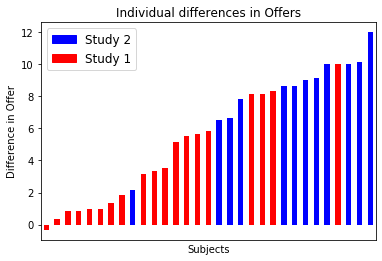

In [17]:
import matplotlib.pyplot as plt

colors = {1: 'r', 2: 'b', 3: 'g'}

datwo=Diffs_All.copy()
datwo['Diff_OfferAll_UG_DG_Human']*=2
DAs=datwo.sort_values(by='Diff_OfferAll_UG_DG_Human',ascending=True)[['subjects','Diff_OfferAll_UG_DG_Human','type']]
DAs['Diff_OfferAll_UG_DG_Human'].plot(kind='bar', color=[colors[i] for i in DAs['type']])

L=plt.legend()

frame1 = plt.gca()
plt.title('Individual differences in Offers')#, fontsize=20)
plt.xlabel('Subjects')#, fontsize=18)
plt.ylabel('Difference in Offer')#, fontsize=18)
frame1.legend_.remove()
NA = mpatches.Patch(color='blue', label='Study 2')
EU = mpatches.Patch(color='red', label='Study 1')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.legend(handles=[NA,EU], loc=2, prop={'size': 12})
plt.savefig('/data/sebastian/UG/manuscript/figures/Individual-differences-in-offers2.png')
plt.show()


### Correlate Classifcation Accuracy with individual differences in difference in Offers

ToM_UFS_2000
partial correlation pearson: (0.36913675002923124, 0.040991204665960145)


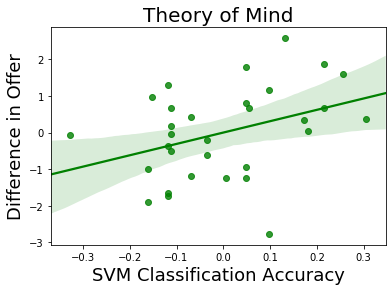

In [112]:


# ROIs can be found in the neural analysis folder
roi_dir='/data/sebastian/UG/ROI_Analysis/'
roi_name='ToM_UFS_2000'

roi_list=[]
print(roi_name)
roi_list.append(roi_name)
w=pd.read_csv(opj(roi_dir,roi_name+'_W.csv'))
m=pd.read_csv(opj(roi_dir,roi_name+'_M.csv'))

#join D1 class. acc. and D1 behavior
joined=pd.merge(diffs_s, m, on='subjects')

#join D2 class. acc. and D2 behavior
joinedW=pd.merge(diffsW, w,on='subjects')

# combine the two datasets
joinedAll=joined.append(joinedW)
covariate=joinedAll['type']-1
behav=joinedAll['Diff_OfferAll_UG_DG']
performance=joinedAll['performance']

# compute partial correlations
iv=performance
dv=behav
# add intercept to covariate
regress = np.vstack([covariate,np.ones(len(covariate))]).T

#perform a normal linear least-squares regression with X as the target and Z as the predictor
iv_regress, residuals, rank, s = np.linalg.lstsq(regress,iv)

#calculate the residuals in Step #1
iv -= regress.dot(iv_regress)

#perform a normal linear least-squares regression with Y as the target and Z as the predictor
dv_regress, residuals, rank, s = np.linalg.lstsq(regress,dv)
dv -= regress.dot(dv_regress)

print('partial correlation pearson: ' + str(pearsonr(iv,dv)))

# plot correlation 
sns.regplot(iv,dv, color='green')
plt.ylabel('Difference in Offer', fontsize=18)
plt.xlabel('SVM Classification Accuracy', fontsize=18)
plt.title('Theory of Mind', fontsize=20)

plt.show()
